# Регуляризация

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

### Загружаем данные 

Задаём коэффициенты исходного многочлена: $ -x^2 + x + 15$ 
Интерпретация: свободный член = 15, коэффициент при x = 1, коэффициент при x^2 = -1

#### Многочлен (Polynomial):
**Многочлен** – это функция, которую можно записать в виде суммы степеней переменной, умноженных на соответствующие коэффициенты. В нашем примере многочлен выглядит $ -x^2 + x + 15$ 

Коэффициенты:
 - Свободный член (константа) равен 15
 - Коэффициент при x равен 1
 - Коэффициент при $ 𝑥^2$ равен -1

#### Функция вычисления многочлена:
Функция ` compute_polynomial ` берёт список коэффициентов и значение x, а затем вычисляет сумму 
  $ coefs[0]+coefs[1]⋅𝑥+coefs[2]⋅𝑥^2$ и так далее.

#### Отрисовка графика многочлена:
Функция ` plot_polynomial ` строит график этого многочлена на интервале $ 𝑥 ∈ [−5,5] $

Это делается для визуализации базовой зависимости, которую мы хотим моделировать.

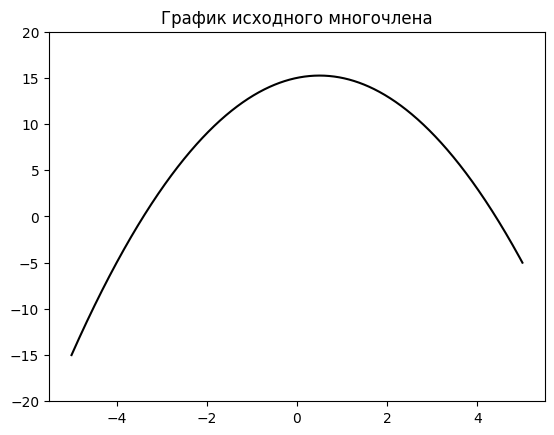

In [2]:
random.seed(0)
np.random.seed(0)

original_coefs = [15, 1, -1]

def compute_polynomial(coefs, x):
    """
    Вычисляет значение многочлена для заданного x.
    
    coefs: список коэффициентов, где coefs[i] соответствует x^i
    x: значение переменной
    """
    n = len(coefs)
    # Вычисляем сумму coefs[i] * x^i для i от 0 до n-1
    return sum([coefs[i] * x**i for i in range(n)])

def plot_polynomial(coefs):
    """
    Строит график многочлена на интервале от -5 до 5.
    
    coefs: список коэффициентов многочлена
    """
    n = len(coefs)
    # Генерируем 1000 точек по оси X от -5 до 5
    x_vals = np.linspace(-5, 5, 1000)
    # Ограничиваем ось Y для лучшей визуализации
    plt.ylim(-20, 20)
    # Вычисляем значения многочлена для всех x
    y_vals = sum([coefs[i] * x_vals**i for i in range(n)])
    # Отрисовываем линию графика
    plt.plot(x_vals, y_vals, linestyle='-', color='black')

# Отрисовываем график исходного многочлена
plot_polynomial(original_coefs)
plt.title("График исходного многочлена")
plt.show()

### Создаем списки для хранения значений x и y
В реальных данных часто присутствует случайная ошибка или колебания, которые называются «шум». Здесь к значению многочлена добавляется гауссовский (нормальный) шум с средним 0 и стандартным отклонением 2. Это делается для того, чтобы данные стали более похожими на реальные.

#### Искусственные данные:
Мы генерируем 40 случайных точек x в диапазоне от -5 до 5, а для каждой точки вычисляем y по формуле:

$ 𝑦 = 𝑃 (𝑥) + шум $

Эти данные затем визуализируются с помощью диаграммы рассеяния (scatter plot).

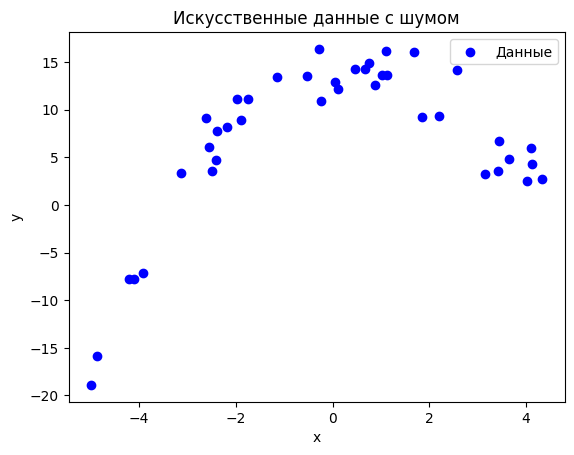

In [3]:

x_points = []
y_points = []
num_samples = 40  # Количество сэмплов

for _ in range(num_samples):
    # Генерируем случайное значение x в диапазоне от -5 до 5
    x_val = random.uniform(-5, 5)
    # Вычисляем y по многочлену и добавляем гауссовский шум (среднее 0, стандартное отклонение 2)
    y_val = compute_polynomial(original_coefs, x_val) + random.gauss(0, 2)
    x_points.append(x_val)
    y_points.append(y_val)

# Визуализируем сгенерированные данные
plt.scatter(x_points, y_points, color='blue', label='Данные')
plt.title("Искусственные данные с шумом")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Формирование таблицы признаков (Feature Engineering)

Полиномиальные признаки (Polynomial Features):
Чтобы построить полиномиальную регрессию, нам нужно создать дополнительные признаки, представляющие степени исходной переменной x.

- Если у нас есть один признак x, мы можем создать признаки $ x^2, x^3, …, \ x^199 $
- Это позволяет модели «увидеть» нелинейные зависимости между x и y.

#### DataFrame с признаками:
Используем библиотеку ` Pandas ` для создания таблицы (DataFrame), где каждая строка соответствует сэмплу, а столбцы – это x и его степени.

In [4]:
# Создаем DataFrame с исходными данными
df = pd.DataFrame({'x': x_points, 'y': y_points})

# Добавляем новые признаки: степени x от 2 до 199
for power in range(2, 200):
    feature_name = f'x^{power}'
    df[feature_name] = df['x'].apply(lambda x: x**power)

# Для корректного построения модели упорядочим признаки по степени: x (степень 1), затем x^2, x^3, ..., x^199
# Создадим список имен признаков с их степенью
def get_degree(col_name):
    if col_name == 'x':
        return 1
    elif '^' in col_name:
        return int(col_name.split('^')[1])
    else:
        return 0

# Отбираем только признаки, относящиеся к x
poly_features = [col for col in df.columns if col.startswith('x')]
poly_features = sorted(poly_features, key=get_degree)

# Выводим таблицу данных
print("Данные после добавления полиномиальных признаков:")
print(df.head())

/tmp/ipykernel_7049/2118263632.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['x'].apply(lambda x: x**power)
/tmp/ipykernel_7049/2118263632.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['x'].apply(lambda x: x**power)
/tmp/ipykernel_7049/2118263632.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

Данные после добавления полиномиальных признаков:
          x          y        x^2        x^3         x^4         x^5  \
0  3.444219   6.685961  11.862641  40.857528  140.722256  484.678199   
1 -2.410832   4.690236   5.812113 -14.012032   33.780661  -81.439516   
2  0.112747  12.205789   0.012712   0.001433    0.000162    0.000018   
3 -1.966873  11.133218   3.868588  -7.609021   14.965976  -29.436170   
4 -0.234030  10.927272   0.054770  -0.012818    0.003000   -0.000702   

           x^6           x^7           x^8           x^9  ...          x^190  \
0  1669.337627  5.749564e+03  1.980275e+04  6.820501e+04  ...  1.114891e+102   
1   196.337032 -4.733357e+02  1.141133e+03 -2.751081e+03  ...   4.090129e+72   
2     0.000002  2.316012e-07  2.611239e-08  2.944099e-09  ...  7.945211e-181   
3    57.897201 -1.138764e+02  2.239804e+02 -4.405410e+02  ...   6.568854e+55   
4     0.000164 -3.845092e-05  8.998685e-06 -2.105966e-06  ...  1.451285e-120   

           x^191          x^192     